In [2]:
import dill as pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from test_utils import extract_labels, get_optimizer, create_dirs
import os 

import random
import numpy as np

import sys
sys.path.append('/Users/matsumoton/Git/digen')
from digen import Benchmark

2.53125


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from os import makedirs
from matplotlib.lines import Line2D


def get_files_name(directory_name, inputname, i, evpop, evgen):
    cx_name = f"{directory_name}{inputname}_run_{i}_pop{evpop}_gen{evgen}_crossover.csv"
    mut_name = f"{directory_name}{inputname}_run_{i}_pop{evpop}_gen{evgen}_mutation.csv"
    return cx_name, mut_name


def determine_better(row):
    if row.offspring <= row.parent1 and row.offspring <= row.parent2:
        return 'worse'
    if row.offspring <= row.parent1 or row.offspring <= row.parent2:
        return 'better than one'
    return 'better than two'


def count_improvement(cx_dfs, mut_dfs):
    cx_counters = [{'worse': 0, 'better than one': 0, 'better than two': 0} for _ in range(len(cx_dfs))]
    for cx_c, cx_df in zip(cx_counters, cx_dfs):
        for row in cx_df.itertuples(index=False):
            offspring_better = determine_better(row)
            cx_c[offspring_better] += 1

    mut_counters = [{'worse': 0, 'better': 0} for _ in range(len(mut_dfs))]
    for mut_c, mut_df in zip(mut_counters, mut_dfs):
        for row in mut_df.itertuples(index=False):
            if row.offspring <= row.parent:
                mut_c['worse'] += 1
            else:
                mut_c['better'] += 1

    return cx_counters, mut_counters


def compute_p_each_generation(cx_dfs, mut_dfs, max_gen):
    cx_ps = [[] for _ in range(1, max_gen)]
    mut_ps = [[] for _ in range(1, max_gen)]
    for g in range(1, max_gen):
        for cx_df in cx_dfs:
            tmp_df = cx_df.loc[cx_df['gen'] == g]
            if tmp_df.shape[0] != 0:
                n_increment = 0
                for row in tmp_df.itertuples(index=False):
                    offspring_better = determine_better(row)
                    if offspring_better != 'worse':
                        n_increment += 1
                p = n_increment / tmp_df.shape[0]
                cx_ps[g - 1].append(p * 100)
        for mut_df in mut_dfs:
            tmp_df = mut_df.loc[mut_df['gen'] == g]
            if tmp_df.shape[0] != 0:
                n_increment = 0
                for row in tmp_df.itertuples(index=False):
                    n_increment += 1 if row.offspring >= row.parent else 0
                p = n_increment / tmp_df.shape[0]
                mut_ps[g - 1].append(p * 100)
    return cx_ps, mut_ps


def compute_aggregate_metrics(counters):
    keys = [k for k in counters[0]]
    aggregate = {k: [] for k in keys}
    for cx_c in counters:
        for k in keys:
            aggregate[k].append(cx_c[k])
    aggregate_metrics = {k: {'mean': np.mean(aggregate[k]),
                             'std': np.std(aggregate[k]),
                             'median': np.median(aggregate[k])}
                         for k in aggregate}
    return aggregate_metrics


def aggregate_metrics(cx_counters, mut_counters):
    cx_metrics = compute_aggregate_metrics(cx_counters)
    mut_metrics = compute_aggregate_metrics(mut_counters)
    return cx_metrics, mut_metrics


def plot_improvements(c_cx, c_mut, title, save_directory, filename):
    plt.figure(figsize=(8, 8))
    plt.bar([1, 2, 3],
            [c_cx['worse']['mean'], c_cx['better than one']['mean'], c_cx['better than two']['mean']],
            alpha=0.9)
    # plot medians
    for x, v in zip([1, 2, 3],
                    [c_cx['worse']['median'], c_cx['better than one']['median'], c_cx['better than two']['median']]):
        plt.plot([x - 0.35, x + 0.35], [v, v], lw=2.5, color='orange', alpha=0.9, zorder=11)
    # plot stds
    for x, m, std in zip([1, 2, 3],
                         [c_cx['worse']['mean'], c_cx['better than one']['mean'], c_cx['better than two']['mean']],
                         [c_cx['worse']['std'], c_cx['better than one']['std'], c_cx['better than two']['std']]):
        plt.plot([x - 0.1, x + 0.1], [m - std, m - std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x - 0.1, x + 0.1], [m + std, m + std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x, x], [m - std, m + std], ls='-', lw=1.5, color='black', alpha=0.8, zorder=10)
    plt.xticks([1, 2, 3],
               ["No improvement", "Improved one parent", "Improved both parents"],
               rotation=30, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f"{title} - Crossover", fontsize=26)
    plt.legend(handles=[Line2D([0], [0], lw=2.5, label='Mean'),
                        Line2D([0], [0], color='orange', lw=2.5, label='Median'),
                        Line2D([0], [0], color='black', lw=1.5, label='Standard Deviation')],
               fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_cx.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_cx.png")

    plt.figure(figsize=(8, 8))
    plt.bar([1, 2],
            [c_mut['worse']['mean'], c_mut['better']['mean']],
            alpha=0.9)
    # plot medians
    for x, v in zip([1, 2], [c_mut['worse']['median'], c_mut['better']['median']]):
        plt.plot([x - 0.35, x + 0.35], [v, v], lw=2.5, color='orange', alpha=0.9, zorder=11)
    # plot stds
    for x, m, std in zip([1, 2],
                         [c_mut['worse']['mean'], c_mut['better']['mean']],
                         [c_mut['worse']['std'], c_mut['better']['std']]):
        plt.plot([x - 0.1, x + 0.1], [m - std, m - std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x - 0.1, x + 0.1], [m + std, m + std], lw=1.5, ls='-', color='black', alpha=0.8, zorder=10)
        plt.plot([x, x], [m - std, m + std], ls='-', lw=1.5, color='black', alpha=0.8, zorder=10)
    plt.xticks([1, 2], ["No improvement", "Improved"],
               rotation=30, fontsize=18)
    plt.yticks(fontsize=18)
    plt.title(f"{title} - Mutation", fontsize=26)
    plt.legend(handles=[Line2D([0], [0], lw=2.5, label='Mean'),
                        Line2D([0], [0], color='orange', lw=2.5, label='Median'),
                        Line2D([0], [0], color='black', lw=1.5, label='Standard Deviation')],
               fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_mut.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_mut.png")


def percentage_metrics(ps):
    means = []
    stds = []
    for gen_p in ps:
        means.append(np.mean(gen_p))
        stds.append(np.std(gen_p))
    return means, stds


def plot_percentage_improvement_vs_generation(cx_p_improvement, mut_p_improvement, max_gen,
                                              title, save_directory, filename):
    cx_mean, cx_std = percentage_metrics(cx_p_improvement)
    mut_mean, mut_std = percentage_metrics(mut_p_improvement)
    plt.figure(figsize=(8, 8))
    plt.plot([i for i in range(1, max_gen)], cx_mean, color='dimgrey', lw=2.5, label="Crossover")
    plt.plot([i for i in range(1, max_gen)], mut_mean, color='darkgreen', lw=2.5, label="Mutation")
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=18)
    plt.xlabel("Generation", fontsize=20)
    plt.ylabel("Improvement percentage", fontsize=20)
    plt.xlim(1, max_gen - 1)
    plt.ylim(0)
    plt.title(f"{title}", fontsize=30)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_percentage.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_percentage.png")


In [ ]:
from os.path import exists

directoryevs = ["baseline","gi_crossover"]

for j in [2,4,7,14,23,24,25,27,28,30,32,35,40]:
    numberofruns = 10
    cx_dfs = []
    mut_dfs = []
    directory = "/Users/matsumoton/Git/results_pop40_gen15_gi_crossover/offspring_generation_test/"
    inputname = "digen" + str(j)
    file_exists = exists(f"{directory}{inputname}_run_0_pop40_gen40_crossover.csv")
    if not file_exists:
        continue
    for i in range(numberofruns):
        cx_df_name, mut_df_name = get_files_name(directory,"digen" + str(j), i, 40, 40)
        cx_dfs.append(pd.read_csv(cx_df_name, sep=','))
        mut_dfs.append(pd.read_csv(mut_df_name, sep=','))
    try:
        makedirs(f"{directory}images/pdf/")
        makedirs(f"{directory}images/png/")
    except:
        pass

    cx_counters, mut_counters = count_improvement(cx_dfs, mut_dfs)
    cx_metrics, mut_metrics = aggregate_metrics(cx_counters, mut_counters)
    print(cx_metrics)
    print(mut_metrics)
    plot_improvements(cx_metrics, mut_metrics, "digen"+str(j), directory, "digen"+str(j))

    cx_p_improvement, mut_p_improvement = compute_p_each_generation(cx_dfs, mut_dfs, 15)
    plot_percentage_improvement_vs_generation(cx_p_improvement, mut_p_improvement, 15,
                                                "digen"+str(j), directory, "digen"+str(j))

In [21]:
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from os import makedirs
from scipy.stats import wilcoxon
from statannot import add_stat_annotation


def get_file_name(directory_name, inputname, i, evpop, evgen):
    df_name = f"{directory_name}{inputname}_run_{i}_evolution_pop{evpop}_gen{evgen}.csv"
    return df_name


def extract_bests(ev_dfs, nev_dfs):
    # extract bests of each generation of evolutions
    max_gen = max(ev_dfs[0]['generation'])
    bests_ev = [[] for _ in range(max_gen + 1)]
    for df in ev_dfs:
        for gen in range(max_gen + 1):
            gen_scores = df.loc[df['generation'] == gen]['score']
            bests_ev[gen].append(max(gen_scores))
    bests_ev = np.array(bests_ev)
    # extract bests of each random sampling
    bests_nev = []
    for df in nev_dfs:
        bests_nev.append(max(df['score']))
    bests_nev = np.array(bests_nev)
    return bests_ev, bests_nev


def compute_medians_bests(bests_ev, bests_nev):
    # median for evolution
    medians_ev = np.median(bests_ev, axis=1)
    # median for no evolution dfs
    median_nev = np.median(bests_nev)
    return medians_ev, median_nev


def plot_boxplots(last_gen_bests, random_bests, score, configname, title, save_directory, filename):
    df_ev_last_gen = pd.DataFrame({'score': last_gen_bests})
    df_ev_last_gen['type'] = configname
    df_nev = pd.DataFrame({'score': random_bests})
    df_nev['type'] = 'Random sampling'
    df = pd.concat((df_ev_last_gen, df_nev))

    _, pvalue = wilcoxon(last_gen_bests, random_bests,
                         zero_method='wilcox', correction=False,
                         alternative='two-sided', mode='auto')
    print(f"Wilcoxon Two-sided pvalue: {pvalue}")

    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    sns.despine(offset=10, trim=False)
    sns.boxplot(x='type', y='score', data=df, ax=ax, showmeans=False, dodge=False)
    add_stat_annotation(ax, data=df, x='type', y='score', perform_stat_test=False,
                        box_pairs=[(configname, 'Random sampling')],
                        pvalues=[pvalue],
                        pvalue_thresholds=[[1e-3, '**'], [1e-2, '*'],
                                           [0.05, '*'], [1, 'ns']],
                        test=None, text_format='star', loc='outside',
                        line_height=0.02, linewidth=2.5, fontsize=24, verbose=0)
    ax.set_xlabel('')
    ax.set_ylabel(f"{score}", fontsize=20)
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=14)
    plt.suptitle(f"{title}", fontsize=30)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_distribution.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_distribution.png", bbox_inches='tight')


def wrap_compute_to_plot(best_medians, FE_per_gen):
    def compute_to_plot(medians, FE):
        to_plot = []
        xs = []
        x = 0
        for m in medians:
            to_plot.append(m)
            xs.append(x)
            to_plot.append(m)
            x += FE
            xs.append(x)
        return to_plot, xs

    to_plot, xs = compute_to_plot(best_medians, FE_per_gen)
    return to_plot, xs


def plot_convergence(ev_best_medians, nev_best_median, FE_per_gen, score, configname, title, save_directory, filename):
    to_plot_nev = [nev_best_median, nev_best_median]
    to_plot_ev, xs = wrap_compute_to_plot(ev_best_medians, FE_per_gen)

    plt.figure(figsize=(8, 8))
    plt.plot([xs[0], xs[-1]], to_plot_nev, color='orange', lw=2.5, label='Random sampling')
    plt.plot(xs, to_plot_ev, color='blue', lw=2.5, label=configname)
    plt.xlabel("Pipeline evaluation", fontsize=20)
    plt.ylabel(f"{score}", fontsize=20)
    plt.title(f"{title}", fontsize=30)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.xlim(0, xs[-1])
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.savefig(f"{save_directory}/images/pdf/{filename}_converegence.pdf")
    plt.savefig(f"{save_directory}/images/png/{filename}_convergence.png")


/Users/matsumoton/opt/anaconda3/envs/tpot_env/lib/python3.10/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon Two-sided pvalue: 0.0014988411849755196


KeyboardInterrupt: 

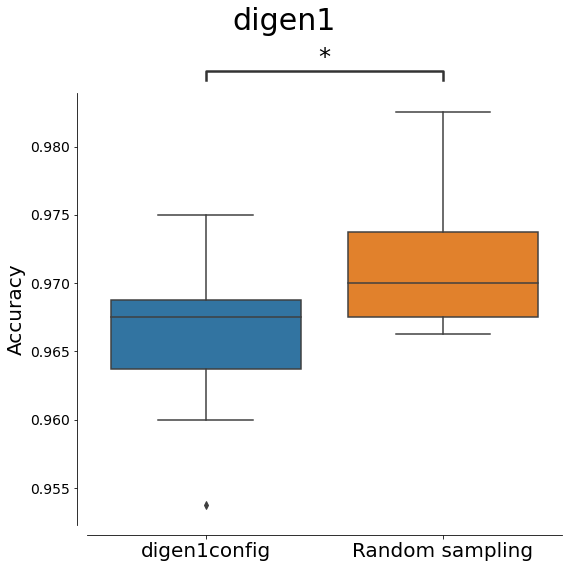

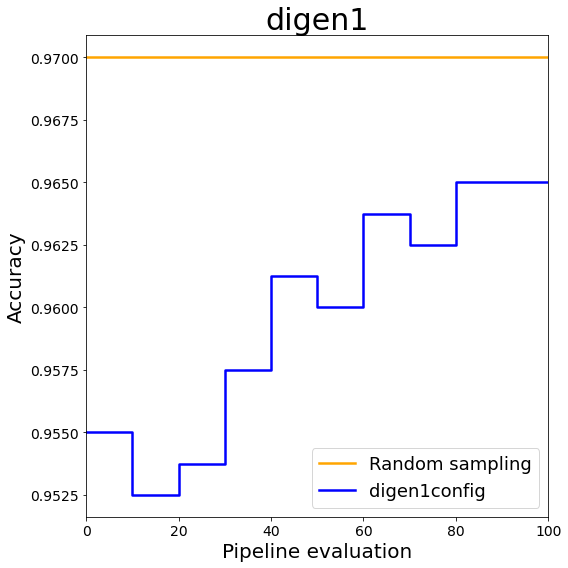

In [24]:
directoryev = "/Users/matsumoton/Git/results_baseline/gen_fitnesses/"
ev_dfs = []
nev_dfs = []

score = 'Accuracy'

for j in range(1,41):
    ev_dfs = []
    nev_dfs = []
    inputname = "digen" + str(j)
    configname = inputname + "config"
    title = inputname
    filename = inputname
    for i in range(numberofruns):
        ev_df_name = f"{directoryev}{inputname}_run_{i}_evolution_pop20_gen10.csv"
        ev_dfs.append(pd.read_csv(ev_df_name, sep=','))
        nev_df_name = f"{directoryev}{inputname}_run_{i}_no_evolution_pop100_gen0.csv"
        nev_dfs.append(pd.read_csv(nev_df_name, sep=','))

    try:
        makedirs(f"{directoryev}images/pdf/")
        makedirs(f"{directoryev}images/png/")
    except:
        pass

    ev_bests, nev_bests = extract_bests(ev_dfs, nev_dfs)
    ev_best_medians, nev_best_median = compute_medians_bests(ev_bests, nev_bests)

    last_gen_bests = [np.max(c) for c in ev_bests.T]
    random_bests = [x for x in nev_bests]
    plot_boxplots(last_gen_bests, random_bests, score, configname, title, directoryev, filename)

    FE_per_gen = 10

    plot_convergence(ev_best_medians, nev_best_median, FE_per_gen, score, configname, title, directoryev,
                        filename)

In [1]:
import os
os.chdir('/Users/matsumoton/Git/tpot_benchmarking')
print(os.getcwd())
from tpot.tpot import TPOTClassifier
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from test_utils import extract_labels, get_optimizer, create_dirs


import openml
import pandas as pd
from openml.datasets import edit_dataset, fork_dataset, get_dataset
 # This is done based on the dataset ID.
dataset = openml.datasets.get_dataset(1164)

# Print a summary
print(
    f"This is dataset '{dataset.name}', the target feature is "
    f"'{dataset.default_target_attribute}'"
)
print(f"URL: {dataset.url}")
print(dataset.description[:500])

X, y, categorical_indicator, attribute_names = dataset.get_data(
    dataset_format="array", target=dataset.default_target_attribute
)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8,random_state=5)

#digits = load_digits()
#X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target,train_size=0.75, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape



/Users/matsumoton/Git/tpot_benchmarking
2.53125
This is dataset 'AP_Endometrium_Uterus', the target feature is 'Tissue'
URL: https://api.openml.org/data/v1/download/54047/AP_Endometrium_Uterus.arff
**Author**:   
**Source**: Unknown - Date unknown  
**Please cite**:   

GEMLeR provides a collection of gene expression datasets that can be used for benchmarking gene expression oriented machine learning algorithms. They can be used for estimation of different quality metrics (e.g. accuracy, precision, area under ROC curve, etc.) for classification, feature selection or clustering algorithms.

This repository was inspired by an increasing need in machine learning / bioinformatics communities f


((148, 10935), (37, 10935), (148,), (37,))

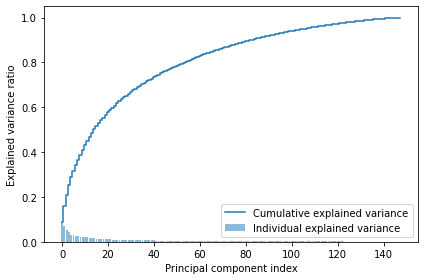

In [17]:
import sklearn.decomposition
import numpy as np
import matplotlib.pyplot as plt
# Instantiate PCA
#
pca = decomposition.PCA()
#
# Determine transformed features
#
X_train_pca = pca.fit_transform(X_train_std)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [18]:
exp_var_pca

array([8.8210359e-02, 7.0886120e-02, 5.1611274e-02, 4.4747870e-02,
       3.1382047e-02, 2.9136149e-02, 2.5107743e-02, 2.4355579e-02,
       2.3528580e-02, 2.1284571e-02, 2.0286333e-02, 1.9795828e-02,
       1.8350577e-02, 1.6577961e-02, 1.5768850e-02, 1.3979936e-02,
       1.3856016e-02, 1.3054941e-02, 1.2421572e-02, 1.1780609e-02,
       1.1245822e-02, 1.0441891e-02, 1.0074229e-02, 9.8397769e-03,
       9.7227786e-03, 9.1858897e-03, 8.7880250e-03, 8.5602105e-03,
       8.2416143e-03, 7.9613570e-03, 7.8919744e-03, 7.4135554e-03,
       7.1611498e-03, 6.9767623e-03, 6.7103985e-03, 6.5905056e-03,
       6.5012504e-03, 6.3884496e-03, 6.1244732e-03, 6.0603423e-03,
       5.9416476e-03, 5.7772403e-03, 5.6067775e-03, 5.5156746e-03,
       5.4597845e-03, 5.3077675e-03, 5.0373739e-03, 4.9276571e-03,
       4.9007279e-03, 4.7832145e-03, 4.7459882e-03, 4.6546012e-03,
       4.5432299e-03, 4.4547971e-03, 4.3643853e-03, 4.2720260e-03,
       4.2079096e-03, 4.1392446e-03, 4.0791216e-03, 4.0308950e